## 主成分分析(PCA)による教師なし次元削減

* 分散が最大となる方向を見つけ出し、元の次元と同じかそれよりも低い次元の新しい部分空間へ射影する。
* 部分空間の直交軸（主成分）を分散が最大となる方向とみなすことができる。
* PCAの方向はデータのスケーリングに対して敏感なため、特徴量の標準化が必要な場合がある。

#### PCAのステップ

1. \\( d \\)次元のデータセットを標準化
1. 標準化したデータセットの共分散行列を作成する
1. 共分散行列を固有ベクトルと固有値に分解する
1. 最も大きい\\( k \\)個の固有値に対応する\\( k \\)個の固有ベクトルを選択する
1. 上位\\( k \\)個の固有ベクトルから射影行列\\( {\boldsymbol W} \\)を作成する
1. 射影行列\\( {\boldsymbol W} \\)を使って\\( d \\)次元の入力データセット\\( {\boldsymbol X} \\)を作成し、新しい\\( k \\)次元の特徴部分空間を取得する

以下ではまずscikit-learnの機能を使わずに主成分分析を行う。

In [2]:
# データの取得と前処理（標準化）
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

C:\Users\tono\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 共分散行列の固有対を求める

特徴量のペアごとの共分散を共分散行列として保持する。

共分散行列を\\( \Sigma \\)で表す。固有ベクトル\\( {\boldsymbol v} \\)、固有値\\( \lambda \\)との関係は以下の通り

$$ \Sigma{\boldsymbol v} = \lambda{\boldsymbol v} $$

下記np.linalg.eigでWineデータセットの共分散行列の固有対を取得する。

In [3]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(eigen_vals)
print(eigen_vecs)

[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]
[[  1.46698114e-01  -5.04170789e-01   1.17235150e-01  -2.06254611e-01
    1.87815947e-01   1.48851318e-01  -1.79263662e-01  -5.54687162e-02
   -4.03054922e-01  -4.17197583e-01   2.75660860e-01   4.03567189e-01
    4.13320786e-04]
 [ -2.42245536e-01  -2.42168894e-01  -1.49946576e-01  -1.30489298e-01
   -5.68639776e-01   2.69052764e-01  -5.92636731e-01   3.32731614e-02
   -1.01833706e-01   2.17101488e-01  -8.13845005e-02  -1.52474999e-01
   -8.78560762e-02]
 [ -2.99344215e-02  -2.86984836e-01  -6.56394387e-01  -1.51536318e-02
    2.99209426e-01   9.33386061e-02   6.07334578e-02  -1.00618575e-01
    3.51841423e-01   1.28549846e-01  -1.29751275e-02   1.68376064e-01
   -4.52518598e-01]
 [ -2.55190023e-01   6.46871827e-02  -5.84282337e-01   9.04220851e-02
    4.12499478e-02   1.01342392e-01   2.50323869e-01   5.61658566e-02
   -5.0045

* 上記固有ベクトルから、データに含まれる大半の情報を含んでいるもの（主成分）を選択する。
* 固有値が固有ベクトルの大きさを表しているため、固有値の大きい順に並べ替えて判定する。

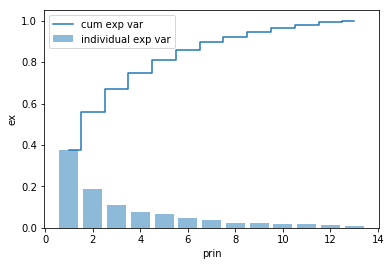

In [4]:
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, alpha=0.5, align='center', label='individual exp var')
plt.step(range(1,14), cum_var_exp, where='mid', label='cum exp var')
plt.ylabel('ex')
plt.xlabel('prin')
plt.legend(loc='best')
plt.show()

### 特徴変換

* Wineデータセットを新しい主成分軸に変換する


In [9]:
# 固有値の大きいものから固有対を並び替える
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
# 最も大きい２つの固有値に対応する固有ベクトルを集める
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n',w)

Matrix W:
 [[ 0.14669811 -0.50417079]
 [-0.24224554 -0.24216889]
 [-0.02993442 -0.28698484]
 [-0.25519002  0.06468718]
 [ 0.12079772 -0.22995385]
 [ 0.38934455 -0.09363991]
 [ 0.42326486 -0.01088622]
 [-0.30634956 -0.01870216]
 [ 0.30572219 -0.03040352]
 [-0.09869191 -0.54527081]
 [ 0.30032535  0.27924322]
 [ 0.36821154  0.174365  ]
 [ 0.29259713 -0.36315461]]


In [13]:
# 124 x 13 の特徴量を124 x 2 に変換
X_train_pca = X_train_std.dot(w)
print(X_train_std.shape)
print(w.shape)
print(X_train_pca.shape)

(124, 13)
(13, 2)
(124, 2)


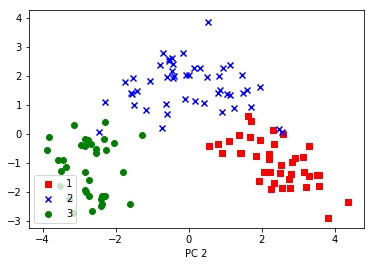

In [16]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.xlabel('PC 2')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# scikit-learnのPCAクラスを使用した場合
